In [1]:
using DifferentialEquations, Flux, DiffEqFlux, StochasticDiffEq, Plots, DiffEqMonteCarlo, CSV, DataFrames

In [6]:
include("../sips.jl")
include("../utils.jl")
using .Sips
using .Utils

In [7]:
dfs = Utils.adj_all_games()

140-element Array{Any,1}:
 668×35 DataFrame. Omitted printing of 30 columns
│ Row │ sport  │ league │ game_id │ a_team           │ h_team                │
│     │ String │ String │ Int64   │ String           │ String                │
├─────┼────────┼────────┼─────────┼──────────────────┼───────────────────────┤
│ 1   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 2   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 3   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 4   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 5   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 6   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 7   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 8   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ Golden State Warriors │
│ 9   │ BASK   │ NBA    │ 4253821 │ Sacramento Kings │ 

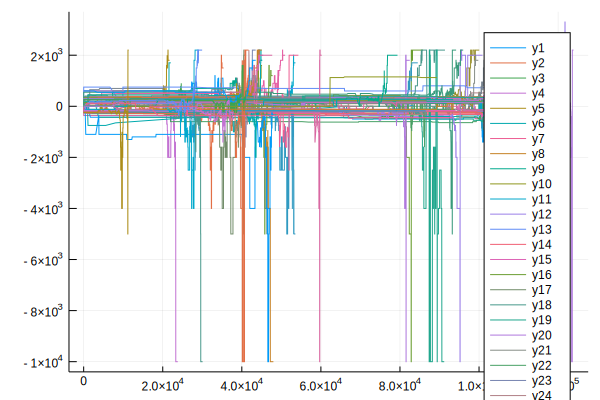

In [8]:
Utils.plot_all(dfs, all=true)

In [15]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = -(-δ*y + γ*x*y)
end
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0,tspan,p)
sol = solve(prob,Tsit5())
using Plots
plot(sol)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase C:\Users\Anand\.julia\packages\DiffEqBase\pqp0B\src\integrator_interface.jl:156


In [16]:
using Flux, DiffEqFlux
p = param([2.2, 1.0, 2.0, 0.4]) # Initial Parameter Vector
params = Flux.Params([p])

Params([[2.2, 1.0, 2.0, 0.4] (tracked)])

In [17]:
u0 = Float32[2.; 0.] |> gpu
datasize = 30
tspan = (0.0f0,1.0f0)
 
function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1] |> gpu
    du .= ((u.^3)'true_A)'
end
t = range(tspan[1],tspan[2],length=datasize)
mp = Float32[0.2,0.2] |> gpu
function true_noise_func(du,u,p,t)
    du .= mp.*u
end
prob = SDEProblem(trueODEfunc,true_noise_func,u0,tspan)
 

SDEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 1.0f0)
u0: Float32[2.0, 0.0]

In [18]:
# Take a typical sample from the mean
monte_prob = MonteCarloProblem(prob)
monte_sol = solve(monte_prob,SOSRI(),num_monte = 100)
monte_sum = MonteCarloSummary(monte_sol)
sde_data = Array(timeseries_point_mean(monte_sol,t))

2×30 Array{Float32,2}:
 2.0  1.97334   1.9094   1.73643  1.41473  …   0.405181   0.559224   0.68735 
 0.0  0.539745  1.05853  1.47442  1.73482     -1.22809   -1.1205    -0.991198